# **Imports**

Below are all the imports used in the **Notebook**.

In [ ]:
# Common
import os 
import keras 
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
from IPython.display import clear_output as cls

# Data 
from keras.preprocessing.image import ImageDataGenerator as IDG

# Data Visualization
import matplotlib.pyplot as plt
import plotly.express as px

# Model
from keras.models import Sequential, load_model
from keras.layers import Dense
from tensorflow.keras.optimizers.schedules import PiecewiseConstantDecay
from tensorflow.keras.optimizers import SGD

# Callbacks 
from keras.callbacks import EarlyStopping, ModelCheckpoint

# **Data Information**

Before loading the data, we should have a look at the **Data Distribution**.

In [ ]:
train_path = "../input/10-species-of-monkey-multiclass-classification/Monkey Species Data/Monkey Species Data/Training Data"
test_path = '../input/10-species-of-monkey-multiclass-classification/Monkey Species Data/Monkey Species Data/Prediction Data'

# Class names
class_names = sorted(os.listdir(train_path))
n_classes = len(class_names)

# Show
print(f"Num Classes : {n_classes}")
print(f"Class Names : {class_names}")

We have **10 Classes**, it is important to have a clear **Class Distribution** for having a perfect **Training Data**.

In [ ]:
# Calculate Class Distribution 
class_dis = [len(os.listdir(train_path + f"/{name}")) for name in class_names]

In [ ]:
# Pie Plot
fig = px.pie(names=class_names, values=class_dis, hole=0.4, title="Training Class Distribution")
fig.update_layout({'title':{'x':0.5}})
fig.show()

# Bar Plot
fig = px.bar(x=class_names, y=class_dis, color=class_names)
fig.show()

All the **classes are equally distributed**, this ensures that **our model cannot be biased towards any class**.

In [ ]:
# Calculate Class Distribution 
class_dis = [len(os.listdir(test_path + f"/{name}")) for name in class_names]

# Pie Plot
fig = px.pie(names=class_names, values=class_dis, hole=0.4, title="Validation Class Distribution")
fig.update_layout({'title':{'x':0.45}})
fig.show()

# Bar Plot
fig = px.bar(x=class_names, y=class_dis, color=class_names)
fig.show()

This **imbalanced class distribution** in intentionally done to represent some **sense of real world data**. As in the read world the model is not going to all the **images equal number of times**.

# **Data Loading**

Now, as we are aware of **Class distribution** we can move towards **loading the data**.

In [ ]:
# Initialize Generator
train_gen = IDG(
    rescale=1./255,
    rotation_range=10,
    horizontal_flip=True,
    validation_split=0.1,
)

test_gen = IDG(rescale=1./255,)

# Load Data
BATCH_SIZE = 32
train_ds = train_gen.flow_from_directory(train_path, subset='training', target_size=(256,256), shuffle=True, class_mode='binary', batch_size=BATCH_SIZE)
valid_ds = train_gen.flow_from_directory(train_path, subset='validation', target_size=(256,256), shuffle=True, class_mode='binary', batch_size=BATCH_SIZE)
test_ds = test_gen.flow_from_directory(test_path, target_size=(256,256), shuffle=True, class_mode='binary', batch_size=BATCH_SIZE)

# **Data Visualization**

The best way to **understand the problem** and **frame a solution** for it is to have a **look at the problem**. In this case, let's **visualize the images**.

In [ ]:
def show_images(data, model=None, GRID=[5,6], SIZE=(25,25)):
    
    # Plot Configurations
    n_rows, n_cols = GRID
    n_images = n_rows * n_cols
    plt.figure(figsize=SIZE)
    
    i = 1
    for images, labels in iter(data):
        
        # Select Random Data
        
        id = np.random.randint(len(images))
        image, label = tf.expand_dims(images[id], axis=0), class_names[int(labels[id])]
        
        # Make Prediction
        if model is not None:
            pred = class_names[np.argmax(model.predict(image))]
            title = f"True : {label}\nPred : {pred}"
        else:
            title = f"{label}"
        
        # Show Data
        plt.subplot(n_rows, n_cols, i)
        plt.imshow(image[0])
        plt.axis('off')
        plt.title(title)
        
        # Break Loop Once Done
        i+=1
        if i>n_images:
            break
        cls()
    plt.show()

In [ ]:
show_images(data=train_ds)

# **Big Transfer Model - BiT**

From architecture perspective **BiT** is nothing but a **4x times Scaled version of ResNet152V2**. The main idea here is of **Transfer Learning**, this model is **pre-trained on a Large Dataset**, so it can be trained on **sub-datasets** or basically other **small datasets** and as the **model is pre-trained on a Very large Dataset** it is expected that it will perform **extremely well on the small dataset**. There are **3 variants of BiT** :

* **BiT-L** : This is trained on **Image Classification task of 300M Samples(This is Private)**.
* **BiT-M** : This is trained on **Image Classification task of 14M Samples**.
* **BiT-S** : This is trained on **Image Classification task of 1.3M Samples**.



In [ ]:
# Model URL
model_url = "https://tfhub.dev/google/bit/m-r50x1/1"

# Load From HUB
bit = hub.KerasLayer(model_url)

In [ ]:
# Model Architecture
model_name = "BiT-Monkey-Species"
model = Sequential([
    bit, 
    Dense(n_classes, activation='softmax', kernel_initializer='zeros')
], name=model_name)

In [ ]:
# Optimizer & LR Scheduler
learning_rate = 1e-3
SCHEDULE_BOUNDARIES = [
    200,
    300,
    400,
]  # more the dataset size the schedule length increase

In [ ]:
lr_scheduler = PiecewiseConstantDecay(
    boundaries=SCHEDULE_BOUNDARIES,
    values=[
        learning_rate,
        learning_rate*0.1,
        learning_rate*0.01,
        learning_rate*0.001,
    ]
)

In [ ]:
opt = SGD(learning_rate=lr_scheduler, momentum=0.9)

In [ ]:
# Compile Model
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=opt,
    metrics=[
        keras.metrics.SparseCategoricalAccuracy(name="Accuracy"),
        keras.metrics.SparseTopKCategoricalAccuracy(k=3, name="Top3Acc")
    ]
)

In [ ]:
# Callbacks
cbs = [EarlyStopping(patience=3, restore_best_weights=True), ModelCheckpoint(model_name + ".h5", save_best_only=True)]

In [ ]:
# Train Model
# history = model.fit(train_ds, validation_data=valid_ds, epochs=10, callbacks=cbs)

# **Learning Curve**

In [ ]:
# pd.DataFrame(history.history).plot(figsize=(10,5))
# plt.grid()
# plt.show()

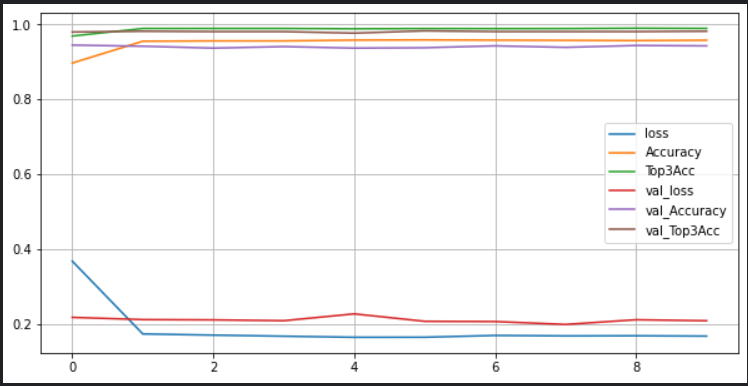

# **Model Evaluation**

In [ ]:
model = load_model("../input/monkey-species-bigtransferbit-acc-95/BiT-Monkey-Species.h5", custom_objects={"KerasLayer":bit})

In [ ]:
model.evaluate(test_ds)

# **Model Predictions**

In [ ]:
show_images(data=test_ds, model=model)

Wow, almost all the **predictions are correct**. The model achieved the **98% top three accuracy** for all the **three datasets**. The **top one accuracies** are :
* **95% Training Accuracy**
* **94% Validation Accuracy**
* **93% Testing Accuracy**

**Thank You**

---
**DeepNets**